# Exampe: cylinder as a large-scale problem

This notebook shows how to solve a large-scale multi-parameter problem on a GPU machine. The problem is similar to the one in [cylinder_user_defined.ipynb](cylinder_user_defined.ipynb) but with a higher resolution for both the parameter distributions and $q$-vectors. **Note that you need a GPU and a 400 GB RAM to run this notebook.**

In [1]:
# avoid omp error on Mac
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# plotting setups
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'legend.fontsize': 12})
matplotlib.rcParams.update({'axes.titlesize': 14})
matplotlib.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble":  r'\usepackage{bm,upgreek}',
    "font.family": "sans-serif",
    "font.serif": ["Times"]})

# create output dir
from pathlib import Path
result_dir = Path('./output/cylinder_large_scale')
Path(result_dir).mkdir(parents=True, exist_ok=True)
paper_fig_dir = Path('./output/paper_fig')
Path(paper_fig_dir).mkdir(parents=True, exist_ok=True)

# tools
from scipy.interpolate import interp1d
from time import time
import pickle

In [2]:
# uncomment this line to install ffsas
# !pip install ffsas

# ffsas
import torch
import ffsas
ffsas.set_torch_dtype(torch.float64)

from ffsas.models import Cylinder
from ffsas.system import SASGreensSystem
from ffsas.utils import _form_batch_ids
device = 'cuda'

# read results from output folder without computation
# this is for quick examination and visualization of existing results
read_results_from_file = True

# Ground truth

To do inversion, we need some intensity data as input. Here we create the data by modelling, using some noisy parameter distributions, or the ground truth.

### Ground truth of distributions of $l$, $r$, $\theta$, $\phi$


The following function creates a "crazy" distribution by adding up Gaussians and random noise.

In [3]:
def crazy_distribution(x, gaussians, noise_level, fade_start, fade_end, noise_interval=1, seed=0):
    # create
    w_true = torch.zeros(x.shape)
    
    # add Gaussians
    for factor, mean, stddev in gaussians:
        w_true += factor * torch.exp(-((x - mean) / stddev) ** 2)
    
    # add noise
    torch.random.manual_seed(seed)
    len_noise = int(round(len(x) / noise_interval))
    xn0 = torch.arange(1, len_noise + 1) * noise_interval
    xn1 = torch.arange(1, len(x) + 1)
    noise1 = torch.from_numpy(interp1d(xn0, torch.rand(len_noise), fill_value="extrapolate")(xn1))
    noise2 = torch.from_numpy(interp1d(xn0, torch.rand(len_noise), fill_value="extrapolate")(xn1))
    w_true += noise_level * noise1 * noise2
    
    # fade both ends to make it look nicer
    if len(x) >= 3:
        w_true[0:fade_start] = 0.
        w_true[fade_start:fade_end] *= torch.linspace(0, 1, fade_end - fade_start)
        w_true[-fade_start:] = 0.
        w_true[-fade_end:-fade_start] *= torch.linspace(1, 0, fade_end - fade_start)
    
    # normalize to 1
    w_true /= torch.sum(w_true)
    return w_true

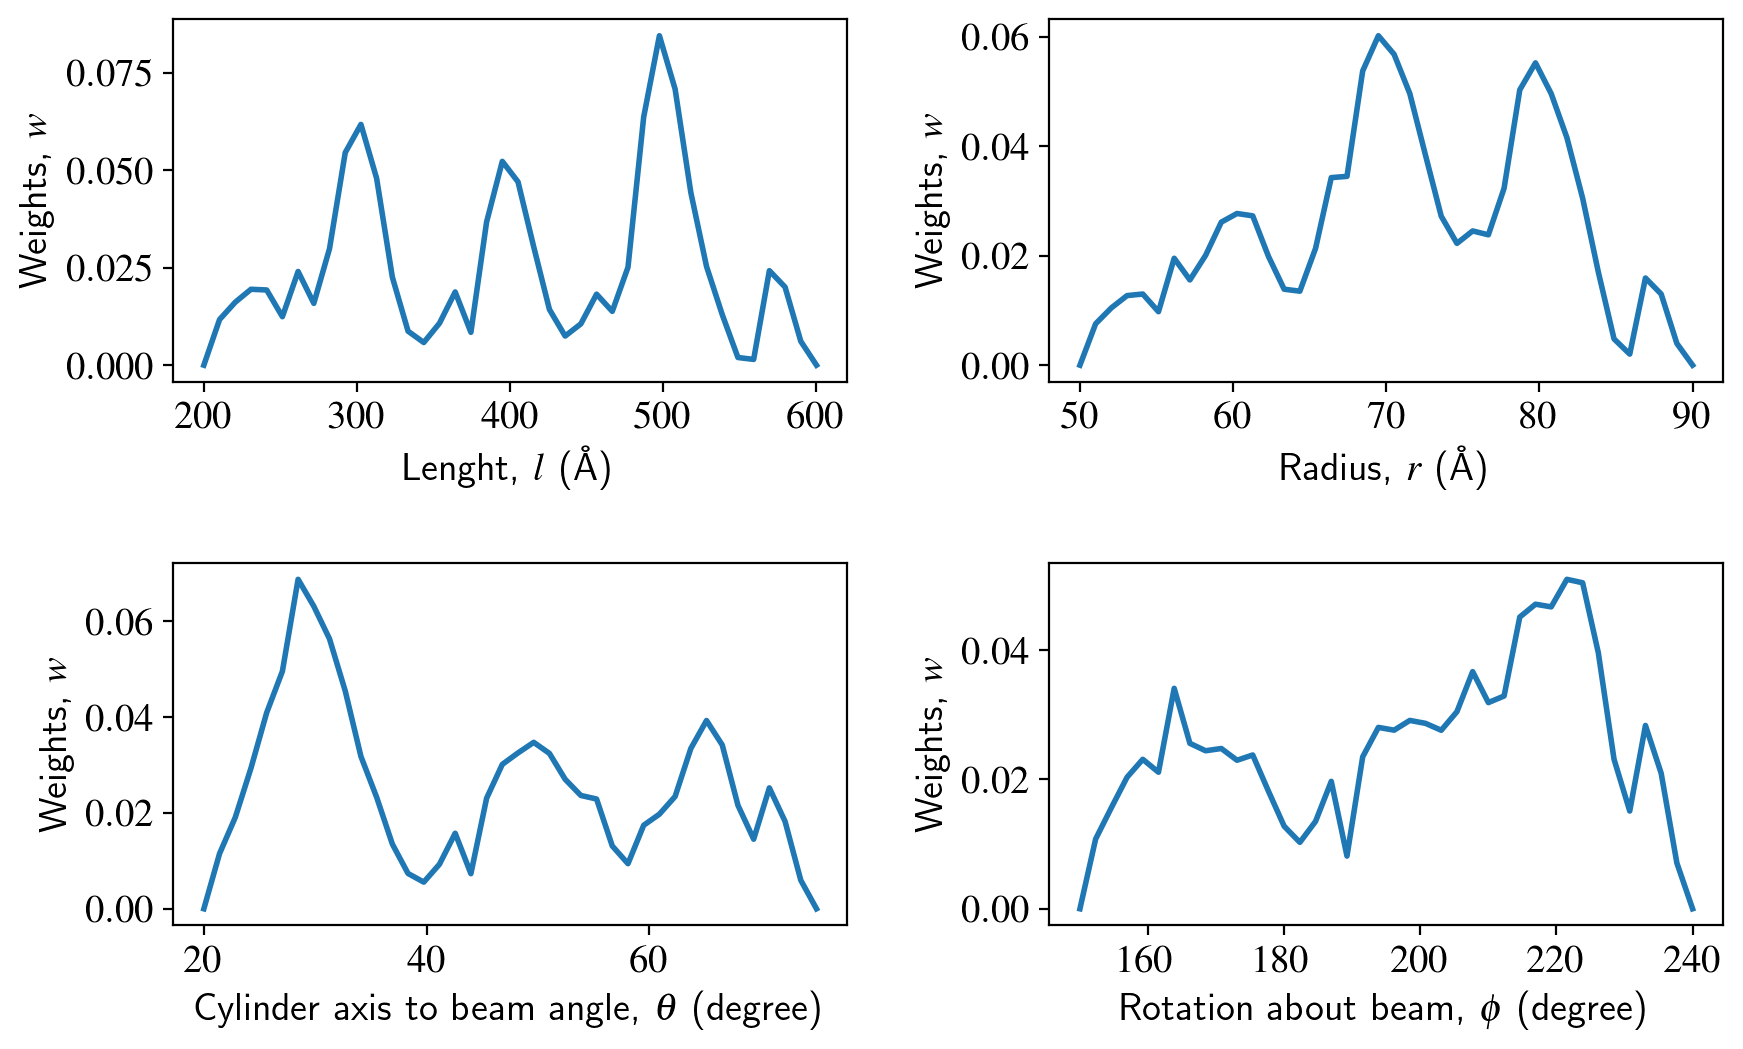

In [4]:
# parameters
par_dict = {
    'l': torch.linspace(200., 600., 40),
    'r': torch.linspace(50., 90., 40),
    'theta': torch.linspace(20., 75., 40),
    'phi': torch.linspace(150., 240., 40)
}

# parameter distributions
w_true_dict = {
    'l': crazy_distribution(par_dict['l'], [(1.5, 300, 20), (1, 400, 20), (2, 500, 20)], 1, 1, 1, 
                            noise_interval=1.2),
    'r': crazy_distribution(par_dict['r'], [(1, 60, 3), (2, 70, 4), (2, 80, 3)], 1, 1, 1, 
                            noise_interval=1.2),
    'theta': crazy_distribution(par_dict['theta'], [(4, 30, 5), (2, 50, 5), (2, 65, 5)], 2, 1, 1, 
                                noise_interval=1.2),
    'phi': crazy_distribution(par_dict['phi'], [(2, 170, 10), (2, 200, 10), (4, 220, 10)], 3, 1, 1, 
                              noise_interval=1.2)
}

# plot distributions
fig, ax = plt.subplots(2, 2, dpi=200, figsize=(10, 6))
plt.subplots_adjust(hspace=.5, wspace=.3)
ax[0, 0].plot(par_dict['l'], w_true_dict['l'], label='Truth')
ax[0, 1].plot(par_dict['r'], w_true_dict['r'], label='Truth')
ax[1, 0].plot(par_dict['theta'], w_true_dict['theta'], label='Truth')
ax[1, 1].plot(par_dict['phi'], w_true_dict['phi'], label='Truth')
ax[0, 0].set_xlabel(r'Lenght, $l$ (\AA)')
ax[0, 1].set_xlabel(r'Radius, $r$ (\AA)')
ax[1, 0].set_xlabel(r'Cylinder axis to beam angle, $\theta$ (degree)')
ax[1, 1].set_xlabel(r'Rotation about beam, $\phi$ (degree)')
ax[0, 0].set_ylabel(r'Weights, $w$')
ax[0, 1].set_ylabel(r'Weights, $w$')
ax[1, 0].set_ylabel(r'Weights, $w$')
ax[1, 1].set_ylabel(r'Weights, $w$')
plt.show()

# degree to radian
par_dict['theta'] = torch.deg2rad(par_dict['theta'])
par_dict['phi'] = torch.deg2rad(par_dict['phi'])

### Ground truth of intensity

Now we compute the true intensity from the above parameter distributions, assuming the truth of $\xi$ and $b$. 

In [5]:
### ground truth of scale and background
scale_true = 0.15
b_true = 2.2e-4

# q vectors
# log scale on the sides
q_side = torch.logspace(-2, 0, 50)
# linear scale in the center
q_center = torch.linspace(-0.0095, 0.0095, 20)
qx = torch.cat((-torch.from_numpy(q_side.numpy()[::-1].copy()), q_center, q_side))
qy = qx.clone()

# (SLD - SLD_solvent) ^ 2
drho = 1.

# batch size
batch_size = 16

In [6]:
if not read_results_from_file:
    # compute the Green's tensor
    G = Cylinder.compute_G_mini_batch([qx, qy], par_dict, {'drho': drho}, batch_size=batch_size, device=device,
                                      fixed_par_weights=None)

    # define the G-based SAS system
    g_sys = SASGreensSystem(G, ['l', 'r', 'theta', 'phi'], batch_size=batch_size, device=device)

    # true xi
    V = Cylinder.compute_V(par_dict)
    V_ave = torch.tensordot(torch.tensordot(V, w_true_dict['r'], dims=1), w_true_dict['l'], dims=1)
    xi_true = (1e-4 * scale_true / V_ave).item()

    # finally compute the ground truth of intensity
    I_true = g_sys.compute_intensity(w_true_dict, xi_true, b_true)

    # free large memory of G
    del G

    # save
    with open(result_dir / 'I_true.pkl', 'wb') as f:
        pickle.dump(I_true, f)

Plot the intensity truth:

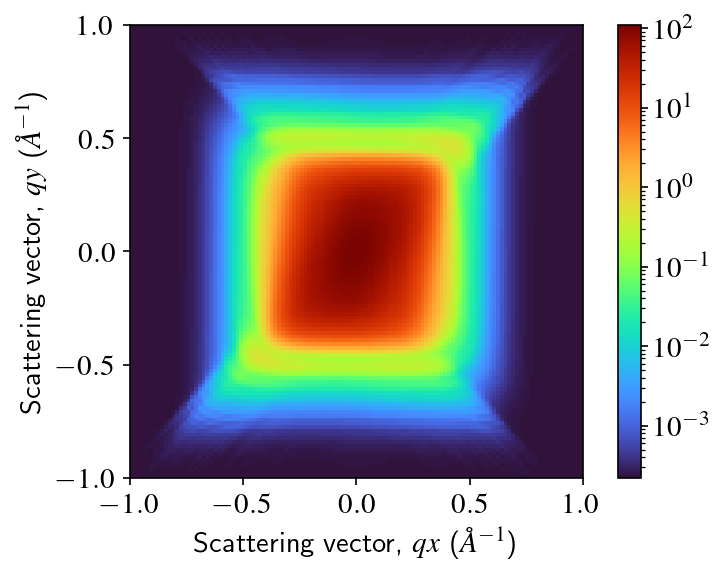

In [7]:
# read from file
with open(result_dir / 'I_true.pkl', 'rb') as f:
    I_true = pickle.load(f)
    
plt.figure(dpi=150)
plt.imshow(I_true.t(), 
           extent=(qx[0], qx[-1], qy[0], qy[-1]), aspect=1., cmap='turbo',
           norm=colors.LogNorm(vmin=I_true.min(), vmax=I_true.max()))
plt.xlabel(r'Scattering vector, $qx$ ($\AA^{-1}$)')
plt.ylabel(r'Scattering vector, $qy$ ($\AA^{-1}$)')
plt.colorbar()
plt.show()

---

#  Inversion

We first conduct a low-resolution solution to privde a good initial guess for the high-resolution one. We lower the resolution of $q_x$ and $q_y$ from 120 to 40, keeping that of the parameter distributions.

In [8]:
if not read_results_from_file:
    # q-vector decimated by 3
    q_decimate = 3
    G_low = Cylinder.compute_G_mini_batch([qx[q_decimate // 2::q_decimate], qy[q_decimate // 2::q_decimate]], 
                                          par_dict, {'drho': drho}, batch_size=batch_size, device=device,
                                          fixed_par_weights=None)

    # define the G-based SAS system
    g_sys_low = SASGreensSystem(G_low, ['l', 'r', 'theta', 'phi'], batch_size=batch_size, device=device)

    # solve low-resolution for 40 iterations
    I_true_low = I_true[q_decimate // 2::q_decimate, q_decimate // 2::q_decimate].clone()
    res_dict_low = g_sys_low.solve_inverse(I_true_low, I_true_low, auto_scaling=True,
                                           maxiter=30, verbose=2, trust_options={'xtol': 0.},
                                           return_intensity_sensitivity=False)

    # save
    with open(result_dir / 'res_dict_low.pkl', 'wb') as f:
        pickle.dump(res_dict_low, f)

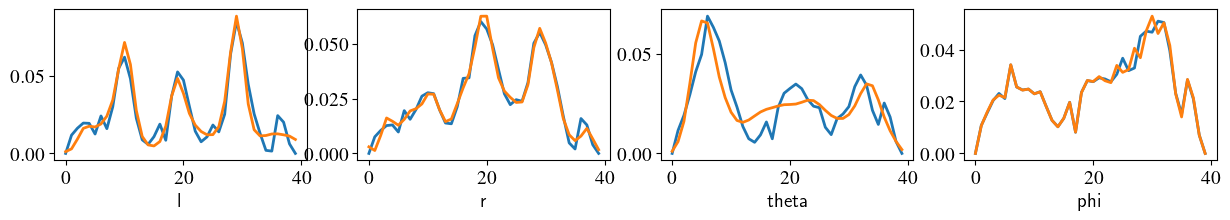

In [9]:
# read from file
with open(result_dir / 'res_dict_low.pkl', 'rb') as f:
    res_dict_low = pickle.load(f)
    
# quick plot
fig, ax = plt.subplots(1, 4, dpi=100, figsize=(15, 2))
for i, (key, val) in enumerate(res_dict_low['w_dict'].items()):
    ax[i].plot(w_true_dict[key])
    ax[i].plot(val)
    ax[i].set_xlabel(key)
plt.show()

Now we perform the high-resolution inversion. We monitor the convergence of each parameter every `check_iter` iterations. If a parameter distribution converges (L1 increment < `L1_tol`), we mark it as constant for further iterations. Only one dimension reduction will significantly speedup the solution.

In [10]:
if not read_results_from_file:
    # use the low-resolution solution as the current state of variables
    # to be updated during solution
    w_dict_cur = res_dict_low['w_dict']
    xi_cur = res_dict_low['xi']
    b_cur = res_dict_low['b']

    # compute the Green's tensor and system
    # to be updated during solution if dimension reduction occurs
    variables = ['l', 'r', 'theta', 'phi']
    G = Cylinder.compute_G_mini_batch([qx, qy], par_dict, {'drho': drho}, 
                                      batch_size=batch_size, device=device,
                                      fixed_par_weights=None)
    g_sys = SASGreensSystem(G, variables, batch_size=batch_size, device=device)

    # batch ids for reducing G
    batch_ids = _form_batch_ids([len(qx), len(qy)], batch_size)

    # L1 tolerance
    L1_tol = 1e-3
    L1_annealing = .1
    # check interval
    check_iter = 10

    # result history
    res_hist = []
    reduce_hist = []
    wtimes = []
    time0 = time()

    # super loop
    for i_check in range(0, 200):
        # invert the G-system
        res_dict = g_sys.solve_inverse(I_true, I_true, auto_scaling=True, 
                                       maxiter=check_iter, verbose=2, trust_options={'xtol': 0.},
                                       w_dict_init=w_dict_cur, xi_init=xi_cur, b_init=b_cur,
                                       return_intensity_sensitivity=False)

        # quick plot
        fig, ax = plt.subplots(1, 4, dpi=100, figsize=(15, 2))
        for i, (key, val) in enumerate(res_dict['w_dict'].items()):
            ax[i].plot(w_true_dict[key])
            ax[i].plot(val)
            ax[i].set_xlabel(key)
        plt.show()

        # save to history
        res_hist.append(res_dict)
        wtimes.append(time() - time0)
        print(f'Done iter={(i_check + 1) * check_iter}, wt={wtimes[-1]}, variables={variables}')

        # check convergence
        L1_diff_min = 1e100
        ivar_min = -1
        for ivar, var in enumerate(variables):
            L1_diff = torch.max(torch.abs(res_dict['w_dict'][var] - w_dict_cur[var]))
            print(f'L1 diff of {var}: {L1_diff.item()}')
            if L1_diff < L1_diff_min:
                L1_diff_min = L1_diff
                ivar_min = ivar

        if L1_diff_min < L1_tol:
            var = variables[ivar_min]
            print(f'**************** Reducing dimension {var}, L1_diff={L1_diff_min} ****************')
            reduce_hist.append([var, i_check])

            # new variables
            variables.remove(var)

            # allocate reduced Green's function
            shape = [len(qx), len(qy)]
            for v in variables:
                shape.append(len(par_dict[v]))
            G_new = torch.zeros(shape)

            # compute reduced Green's function by mini-batch
            w_var = res_dict['w_dict'][var].to(device)
            for i, batch_id in enumerate(batch_ids):
                G_batch = G[tuple(batch_id)].to(device)
                G_new_batch = torch.tensordot(G_batch, w_var, dims=[[ivar_min + 2], [0]])
                G_new[tuple(batch_id)] = G_new_batch.to('cpu')
            del G
            G = G_new

            # define the G-based SAS system
            g_sys = SASGreensSystem(G, variables, batch_size=batch_size, device=device)

            # annealing
            L1_tol *= L1_annealing

        # all converged
        if len(variables) == 0:
            print('All variables converged.')
            break

        # update current
        w_dict_cur = res_dict['w_dict']
        xi_cur = res_dict['xi']
        b_cur = res_dict['b']

    # save so we can skip this cell next time
    with open(result_dir / 'res_hist_annealing.pkl', 'wb') as f:
        pickle.dump(res_hist, f)

    with open(result_dir / 'reduce_hist_annealing.pkl', 'wb') as f:
        pickle.dump(reduce_hist, f)  

    with open(result_dir / 'wtimes_annealing.pkl', 'wb') as f:
        pickle.dump(wtimes, f)

---

# Visualization

First, read and process the results:

In [11]:
# read from file
with open(result_dir / 'res_hist_annealing.pkl', 'rb') as f:
    res_hist = pickle.load(f)
    
with open(result_dir / 'reduce_hist_annealing.pkl', 'rb') as f:
    reduce_hist = pickle.load(f)

with open(result_dir / 'wtimes_annealing.pkl', 'rb') as f:
    wtimes = pickle.load(f)
    
# final results
variables = ['l', 'r', 'theta', 'phi']
final_xi = res_hist[-1]['xi']
final_b = res_hist[-1]['b']
final_w_dict = {}
final_conv_hist = {}

# process convergence history
for var in variables:
    hist = {}
    for i, (v, conv_i) in enumerate(reduce_hist):
        if v == var:
            hist['conv_order'] = i
            hist['conv_i'] = conv_i
            if i == 0:
                hist['wtime'] = wtimes[conv_i]
                hist['nit'] = (conv_i + 1) * 10
            else:
                hist['wtime'] = wtimes[conv_i] - wtimes[reduce_hist[i - 1][1]]
                hist['nit'] = (conv_i + 1) * 10 - (reduce_hist[i - 1][1] + 1) * 10
            break
    final_conv_hist[var] = hist
    final_w_dict[var] = res_hist[hist['conv_i']]['w_dict'][var]

Compute the sensitivity of the MLE:

In [12]:
if not read_results_from_file:
    # compute sensitivity
    G = Cylinder.compute_G_mini_batch([qx, qy], par_dict, {'drho': drho}, 
                                      batch_size=batch_size, device=device,
                                      fixed_par_weights=None)
    g_sys = SASGreensSystem(G, variables, batch_size=batch_size, device=device)
    res_dict_sens = g_sys.solve_inverse(I_true, I_true, auto_scaling=True, 
                                        maxiter=1, verbose=2, trust_options={'xtol': 0.},
                                        w_dict_init=final_w_dict, xi_init=final_xi, b_init=final_b,
                                        return_intensity_sensitivity=True)
    del G

    # save so we can skip this cell next time
    with open(result_dir / 'sen_dict_annealing.pkl', 'wb') as f:
        pickle.dump(res_dict_sens, f)

Plot the parameter distributions:

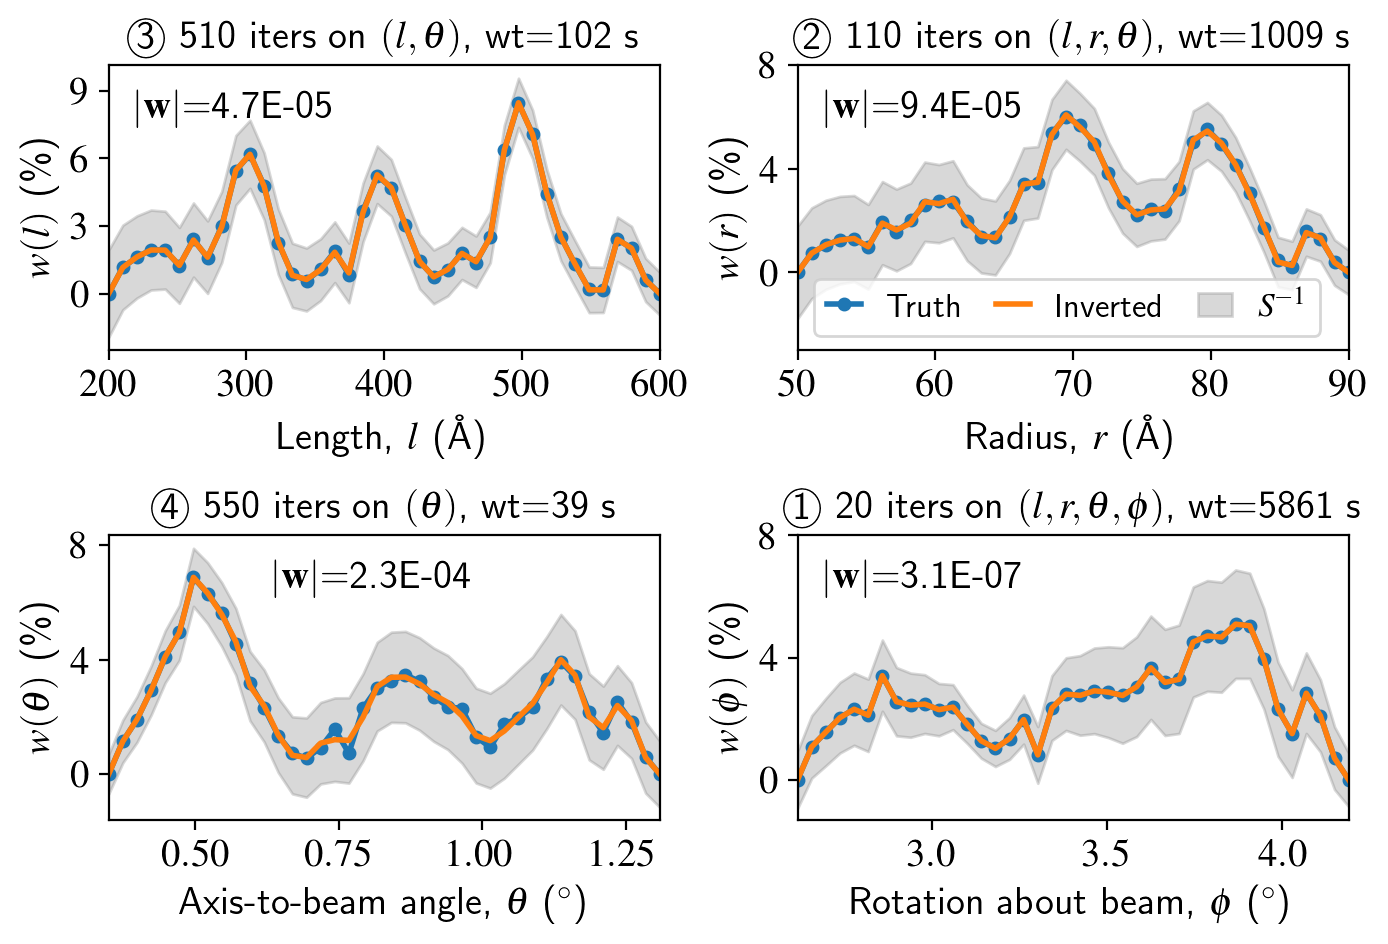

In [13]:
# read sensitivity
with open(result_dir / 'sen_dict_annealing.pkl', 'rb') as f:
    res_dict_sens = pickle.load(f)
    
fig, ax = plt.subplots(2, 2, dpi=200, figsize=(8., 5))
plt.subplots_adjust(hspace=.65, wspace=.25)
axes = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]

# handcraft variables in latex
final_conv_hist['phi']['vars'] = 'l, r, \\theta, \\phi'
final_conv_hist['r']['vars'] = 'l, r, \\theta'
final_conv_hist['l']['vars'] = 'l, \\theta'
final_conv_hist['theta']['vars'] = '\\theta'

scaling_factor_sensitivity = 1e9
for i, axis in enumerate(axes):
    var = variables[i]
    # true
    axis.plot(par_dict[var], w_true_dict[var] * 100, '-o', label='Truth', markersize=4)
    # inverted
    axis.plot(par_dict[var], final_w_dict[var] * 100, label='Inverted')
    # S^-1
    sens_scaled = scaling_factor_sensitivity / res_dict_sens['sens_w_dict'][var]
    axis.fill_between(par_dict[var], 
                      (final_w_dict[var] - abs(sens_scaled)) * 100, 
                      (final_w_dict[var] + abs(sens_scaled)) * 100, 
                      alpha=.3, color='gray', zorder=-100, label=r'$S^{-1}$')
    # convergence
    axis.set_title(r'\textcircled{\raisebox{-0.9pt}{%d}} %d iters on $(%s)$, wt=%d s' % (
        final_conv_hist[var]['conv_order'] + 1, final_conv_hist[var]['nit'],
        final_conv_hist[var]['vars'], final_conv_hist[var]['wtime']), fontsize=14)
    # error
    x = .05 if i != 2 else .3
    axis.text(x, .85, r'$|\mathbf{w}|$=%.1E' % (torch.norm(w_true_dict[var] - 
                                                           final_w_dict[var]) / 40), va='center',
              transform=axis.transAxes)

# settings
ax[0, 0].set_xlabel(r'Length, $l$ (\AA)')
ax[0, 1].set_xlabel(r'Radius, $r$ (\AA)')
ax[1, 0].set_xlabel(r'Axis-to-beam angle, $\theta$ ($^\circ$)')
ax[1, 1].set_xlabel(r'Rotation about beam, $\phi$ ($^\circ$)')
ax[0, 0].set_ylabel(r'$w(l)$ (\%)')
ax[0, 1].set_ylabel(r'$w(r)$ (\%)')
ax[1, 0].set_ylabel(r'$w(\theta)$ (\%)')
ax[1, 1].set_ylabel(r'$w(\phi)$ (\%)')
ax[0, 0].set_xlim(par_dict['l'].min(), par_dict['l'].max())
ax[0, 1].set_xlim(par_dict['r'].min(), par_dict['r'].max())
ax[1, 0].set_xlim(par_dict['theta'].min(), par_dict['theta'].max())
ax[1, 1].set_xlim(par_dict['phi'].min(), par_dict['phi'].max())
ax[0, 0].set_yticks([0, 3, 6, 9])
ax[0, 1].set_yticks([0, 4, 8])
ax[1, 0].set_yticks([0, 4, 8])
ax[1, 1].set_yticks([0, 4, 8])


ax[0, 1].set_ylim(-3, 8)
ax[0, 1].legend(ncol=3, columnspacing=1, handlelength=1, prop={'size':12},
                loc=[.03, .05])

plt.savefig(paper_fig_dir / 'cylinder_w.pdf', bbox_inches='tight', facecolor='w', pad_inches=.1)
plt.show()

Finally, plot the intensity. Here we choose a different discretization of $q_x$ and $q_y$ for better visual effects.

In [14]:
if not read_results_from_file:
    # q vectors
    # log scale on the sides
    q_side = torch.logspace(-1.3, 0, 50)
    # linear scale in the center
    q_center = torch.linspace(-0.05, 0.05, 20)
    qx_v = torch.cat((-torch.from_numpy(q_side.numpy()[::-1].copy()), q_center, q_side))
    qy_v = qx_v.clone()

    # compute the Green's tensor
    G = Cylinder.compute_G_mini_batch([qx_v, qy_v], par_dict, {'drho': drho}, 
                                      batch_size=batch_size, device=device,
                                      fixed_par_weights=None)

    # define the G-based SAS system
    g_sys = SASGreensSystem(G, ['l', 'r', 'theta', 'phi'], batch_size=batch_size, device=device)

    # finally compute the ground truth of intensity
    I_fit = g_sys.compute_intensity(final_w_dict, final_xi, final_b)

    # free large memory of G
    del G

    # save
    with open(result_dir / 'I_fit.pkl', 'wb') as f:
        pickle.dump(I_fit, f)

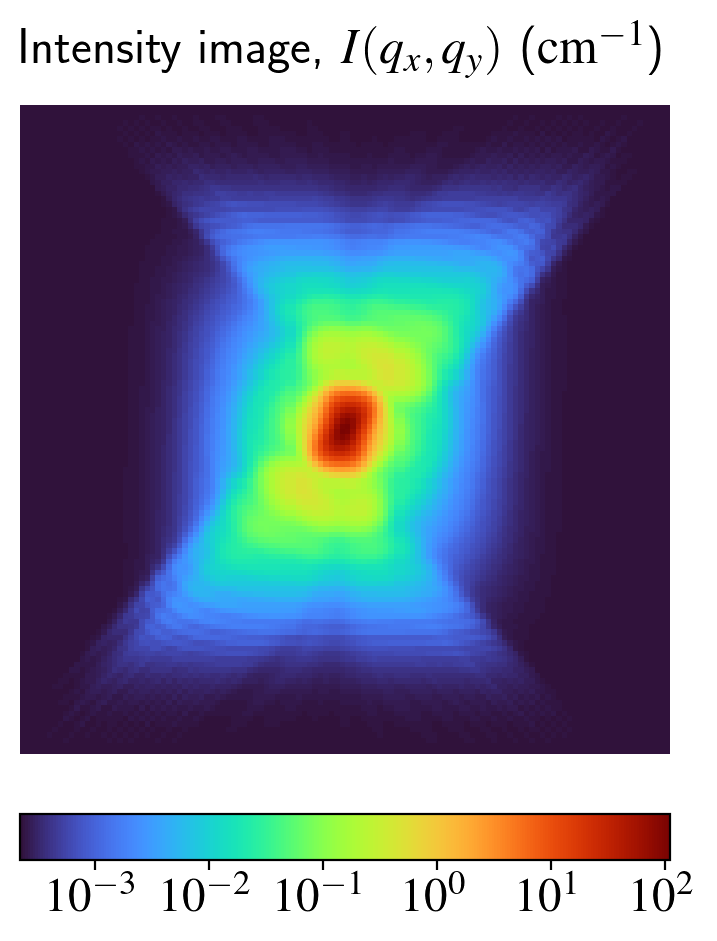

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# read intenstiy
with open(result_dir / 'I_fit.pkl', 'rb') as f:
    I_fit = pickle.load(f)
    
fig = plt.figure(dpi=200, figsize=(5, 5))
im = plt.imshow(I_fit.t(), 
                extent=(qx[0], qx[-1], qy[0], qy[-1]), aspect=1., cmap='turbo',
                norm=colors.LogNorm(vmin=I_true.min(), vmax=I_true.max()))
plt.title(r'Intensity image, $I(q_x, q_y)$ ($\mathrm{cm}^{-1}$)', fontsize=18, pad=15)
plt.axis('off')

divider = make_axes_locatable(plt.gca())
cax = divider.new_vertical(size="7%", pad=.3, pack_start=True)
fig.add_axes(cax)
cbar=fig.colorbar(im, cax=cax, orientation="horizontal", )
cbar.set_ticks([.001, .01, .1, 1, 10, 100])
cbar.ax.tick_params(labelsize=17)

plt.savefig(paper_fig_dir / 'cylinder_I.pdf', bbox_inches='tight', facecolor='w', pad_inches=.1)
plt.show()

In [16]:
print('WCT low-resolutoin:', res_dict_low['wct'])
print('WCT high-resolutoin:',  wtimes[-1])
print('WCT total:', res_dict_low['wct'] +  wtimes[-1])

WCT low-resolutoin: 840.7964065074921
WCT high-resolutoin: 7013.604094028473
WCT total: 7854.400500535965
